# 1. Import libraries

In [9]:
import pandas as pd
import numpy as np 
import pickle
import os

from itertools import cycle
from collections import defaultdict
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

from helper import plot_classifier


# 2. Load data, extract data and label

In [10]:
rootdir = os.getcwd() + "/data/training/"

data             = []
data_label       = []


for subdir, dirs, files in os.walk(rootdir):
    for fl in files:
        if fl.endswith('.pkl'):
            # string split for event labelling
            str_arr = fl.split('_')
            label   = str_arr[1]

            # read data and append it to variable
            infile = open((rootdir + fl),'rb')
            new_dict = pickle.load(infile, encoding='latin1')

            data.append(new_dict)
            data_label.append(new_dict['label'])

# 3. Feature Generation - Mean, Variance, Maximum and Minimum

In [11]:
keys = [
    'Magnetometer', 
    'Accelerometer', 
    'LinearAccelerometer', 
    'JinsGyroscope', 
    'Gravity', 
    'MSAccelerometer',
    'JinsAccelerometer',
    'MSGyroscope',
    'Gyroscope',
    'JinsEyeMovement',
    # 'JinsBlinkStrength', Excluded because some data has no JinsBlinkStrength data
    'rightHand',
    'label'
]

ary = []
for dt in data:
    internal = []
    for key in keys[:-2]:
        feature = dt[key]
        # print(f"Shape von Feature {key}: {feature.shape}")
        for column in feature.T:
            internal.append(np.mean(column))
            internal.append(np.var(column))
            internal.append(np.max(column))
            internal.append(np.min(column))
            
    # Right hand - If true 1 else 0
    right_hand = 1 if dt["rightHand"] else 0
    internal.append(right_hand)

    internal.append(dt["label"])

    ary.append(internal)

# 4. Added columns name to the data frame

In [12]:
df = pd.DataFrame(ary)

# Name df columns, so it's more clear
df_columns = []

# Iterate through except label, rightHand, JinsEyeMovement, JinsBlinkStrength
for key in keys[:-3]:
    df_columns.append('{} X (mean)'.format(key))
    df_columns.append('{} X (var)'.format(key))
    df_columns.append('{} X (max)'.format(key))
    df_columns.append('{} X (min)'.format(key))

    df_columns.append('{} Y (mean)'.format(key))
    df_columns.append('{} Y (var)'.format(key))
    df_columns.append('{} Y (max)'.format(key))
    df_columns.append('{} Y (min)'.format(key))

    df_columns.append('{} Z (mean)'.format(key))
    df_columns.append('{} Z (var)'.format(key))
    df_columns.append('{} Z (max)'.format(key))
    df_columns.append('{} Z (min)'.format(key))

# JinsEyeMovement (4 dimensions)
for i in range(4):
    df_columns.append('JinsEyeMovement Dim-{} (mean)'.format(i+1))
    df_columns.append('JinsEyeMovement Dim-{} (var)'.format(i+1))
    df_columns.append('JinsEyeMovement Dim-{} (max)'.format(i+1))
    df_columns.append('JinsEyeMovement Dim-{} (min)'.format(i+1))

df_columns.append('rightHand')

df_columns.append('label')

df.columns = df_columns

df

,Magnetometer X (mean),Magnetometer X (var),Magnetometer X (max),Magnetometer X (min),Magnetometer Y (mean),Magnetometer Y (var),Magnetometer Y (max),Magnetometer Y (min),Magnetometer Z (mean),Magnetometer Z (var),...,JinsEyeMovement Dim-3 (mean),JinsEyeMovement Dim-3 (var),JinsEyeMovement Dim-3 (max),JinsEyeMovement Dim-3 (min),JinsEyeMovement Dim-4 (mean),JinsEyeMovement Dim-4 (var),JinsEyeMovement Dim-4 (max),JinsEyeMovement Dim-4 (min),rightHand,label
0,4.991582,3.368823,9.3125,1.9375,-32.884439,0.634716,-31.1875,-35.2500,26.872449,0.663769,...,0.0,0.0,0.0,0.0,0.009901,0.009803,1.0,0.0,0,0
1,4.999238,7.892133,7.7500,-2.5625,-40.103659,1.256309,-37.8750,-43.4375,-1.536331,3.767433,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0
2,8.244621,33.212013,14.1250,-1.7500,-37.640113,1.081339,-35.2500,-40.8125,9.581711,26.765016,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0
3,8.289634,0.321695,9.6875,6.6875,-39.676829,0.765797,-37.8750,-41.9375,3.122967,1.000790,...,0.0,0.0,0.0,0.0,0.010000,0.009900,1.0,0.0,0,0
4,18.582317,0.217309,20.0000,17.3750,-39.456047,0.764281,-37.5000,-41.5625,-7.030488,0.467312,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,57.716972,143.881277,70.9375,23.0625,-8.623476,6.323994,-1.8125,-14.3125,54.860010,121.039457,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,5
255,60.309959,32.958549,72.0000,45.8750,-9.146341,3.963309,-3.6875,-13.9375,52.580285,101.322569,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,5
256,62.244157,22.920205,70.1875,49.9375,-10.478659,6.692094,-4.0625,-15.4375,52.757876,97.716036,...,0.0,0.0,0.0,0.0,0.010000,0.009900,1.0,0.0,0,5
257,62.617378,22.964754,72.7500,52.1250,-9.737551,7.747225,-3.3125,-16.5625,51.687246,73.808673,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,5


# 5. Performing a principal Component analysis

In [13]:
X = df.iloc[:, :-1].to_numpy() # All features except label
y = df['label'].to_numpy()

pca = PCA(n_components=10) # CAVE: maybe change the amount of principal components to use

# Standardizing the features
X = StandardScaler().fit_transform(X)

principal_components = pca.fit_transform(X)

principal_df = pd.DataFrame(data=principal_components)

print(pca.explained_variance_ratio_)
print(pca.get_params)
principal_df
# Plot PCA?

[0.26676554 0.12021806 0.07257031 0.05431304 0.04118228 0.0358564
 0.03357949 0.03132181 0.02910508 0.02758197]
<bound method BaseEstimator.get_params of PCA(n_components=10)>


,0,1,2,3,4,5,6,7,8,9
0,0.500421,-6.863498,2.145858,-0.162698,0.122750,2.068390,-1.256282,-1.191374,2.048705,1.749361
1,0.757073,-6.469912,1.516740,2.179937,1.093260,-2.464112,-0.256197,-1.772638,-1.021973,-0.023692
2,1.786152,-5.096255,2.970570,1.780679,0.993268,1.519455,-0.714397,-3.576833,-1.016536,-1.059862
3,1.457373,-6.850520,3.445465,1.428481,0.219990,0.760540,1.387736,-1.219608,2.825068,0.246762
4,-0.021130,-7.020647,0.203493,1.389389,1.345846,-1.578877,-0.914820,-1.175469,0.279583,0.590008
...,...,...,...,...,...,...,...,...,...,...
254,11.956008,3.074924,-2.382447,-4.890816,-2.051571,-4.027934,-2.486797,-0.487992,0.795922,1.364647
255,11.741808,2.864098,-3.871704,-6.180465,-0.571982,-2.295828,-3.963604,-0.605326,0.172115,1.017420
256,13.235819,3.126443,-3.499519,-4.224622,1.126067,0.082467,-1.810819,-2.028401,-0.934184,-1.448425
257,12.801271,2.549879,-3.868923,-4.417748,0.715764,-0.309288,-2.058867,-1.090735,-0.043569,-1.738800


# Feature selections with RandomForestClassifier and SelectFromModel

In [14]:
X = df.iloc[:, :-1]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=42))
sel.fit(X_train, y_train)

sel.get_support()

# Array of columns, that regarded as best features by random forest classifier above
selected_feats = X_train.columns[(sel.get_support())]

selected_feats

Index(['Magnetometer X (mean)', 'Accelerometer X (min)',
       'Accelerometer Y (mean)', 'Accelerometer Y (max)',
       'Accelerometer Y (min)', 'Accelerometer Z (mean)',
       'Accelerometer Z (max)', 'Accelerometer Z (min)',
       'LinearAccelerometer X (var)', 'LinearAccelerometer Y (mean)',
       'LinearAccelerometer Y (var)', 'LinearAccelerometer Y (max)',
       'LinearAccelerometer Y (min)', 'LinearAccelerometer Z (var)',
       'LinearAccelerometer Z (max)', 'LinearAccelerometer Z (min)',
       'JinsGyroscope X (min)', 'JinsGyroscope Y (mean)',
       'JinsGyroscope Y (max)', 'JinsGyroscope Y (min)', 'Gravity X (mean)',
       'Gravity X (min)', 'Gravity Y (mean)', 'Gravity Y (var)',
       'Gravity Y (max)', 'Gravity Y (min)', 'Gravity Z (mean)',
       'Gravity Z (max)', 'Gravity Z (min)', 'MSAccelerometer X (mean)',
       'MSAccelerometer X (max)', 'MSAccelerometer X (min)',
       'JinsAccelerometer Y (mean)', 'JinsAccelerometer Y (max)',
       'JinsAccelerometer Y 

# RandomForestClassifier without pre-processing

In [15]:
# X = principal_components # All features except label
X = df.iloc[:, :-1].to_numpy() # All features except label
y = df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

# Cross fold validation - 10 folds
scores = cross_val_score(clf, X, y, cv=10)

# Scores value
print (f"Score: {clf.score(X_test, y_test)}")
print(f"cross fold validation scores: {scores}")
print(f"cross fold validation score average: {scores.mean()}")
print(f"cross fold validation score standard deviation: {scores.std()}")

Score: 0.9615384615384616
cross fold validation scores: [0.96153846 0.96153846 1.         0.92307692 0.92307692 1.
 0.96153846 1.         0.96153846 1.        ]
cross fold validation score average: 0.9692307692307693
cross fold validation score standard deviation: 0.02878197989826107


# RandomForestClassifier with selected features

In [16]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

# Cross fold validation - 10 folds
scores = cross_val_score(clf, X, y, cv=10)

# Scores value
print (f"Score: {clf.score(X_test, y_test)}")
print(f"cross fold validation scores: {scores}")
print(f"cross fold validation score average: {scores.mean()}")
print(f"cross fold validation score standard deviation: {scores.std()}")

Score: 0.9807692307692307
cross fold validation scores: [0.96153846 0.96153846 1.         0.92307692 0.92307692 1.
 0.96153846 1.         0.96153846 1.        ]
cross fold validation score average: 0.9692307692307693
cross fold validation score standard deviation: 0.02878197989826107


# Logistic Regression with StandardScaler and selected features

In [17]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

# Standardizing the features
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = LogisticRegression(random_state=0, solver="saga", max_iter=1000).fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=10)

# Scores value
print(f"Score: {clf.score(X_test, y_test)}")
print(f"cross fold validation scores: {scores}")
print(f"cross fold validation score average: {scores.mean()}")
print(f"cross fold validation score standard deviation: {scores.std()}")

Score: 0.9534883720930233
cross fold validation scores: [0.96153846 0.92307692 1.         0.88461538 0.92307692 1.
 0.96153846 0.96153846 0.96153846 0.96      ]
cross fold validation score average: 0.9536923076923077
cross fold validation score standard deviation: 0.03349785827296634


# SVM with StandardScaler and selected features

In [18]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

# Standardizing the features
X = StandardScaler().fit_transform(X)

clf = SVC(gamma='auto', random_state=0).fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=10)

# Scores value
print(f"Score: {clf.score(X_test, y_test)}")
print(f"cross fold validation scores: {scores}")
print(f"cross fold validation score average: {scores.mean()}")
print(f"cross fold validation score standard deviation: {scores.std()}")

Score: 0.9418604651162791
cross fold validation scores: [0.96153846 0.92307692 0.96153846 0.88461538 1.         1.
 0.96153846 0.96153846 0.96153846 1.        ]
cross fold validation score average: 0.9615384615384615
cross fold validation score standard deviation: 0.034401045807689073


# KNN with StandardScaler and selected features

In [19]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=10)

# Scores value
print(f"Score: {clf.score(X_test, y_test)}")
print(f"cross fold validation scores: {scores}")
print(f"cross fold validation score average: {scores.mean()}")
print(f"cross fold validation score standard deviation: {scores.std()}")

Score: 0.9418604651162791
cross fold validation scores: [0.73076923 0.88461538 0.84615385 0.80769231 0.80769231 0.88461538
 0.92307692 0.96153846 0.96153846 1.        ]
cross fold validation score average: 0.8807692307692306
cross fold validation score standard deviation: 0.07966275068156917


# Naive Bayes without standardization necessary with selected features

In [20]:
X = df.iloc[:, :-1].to_numpy() # All features except label
# X = df.iloc[selected_feats].to_numpy()
y = df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

clf = MultinomialNB()
clf.fit(X_train, y_train)

print(f"Score: {clf.score(X_test, y_test)}")
print(f"cross fold validation scores: {scores}")
print(f"cross fold validation score average: {scores.mean()}")
print(f"cross fold validation score standard deviation: {scores.std()}")

proba = clf.predict_proba(X_train)

np.set_printoptions(suppress=True)
print(f"Probabilites per dataset: {proba}")

df_proba = pd.DataFrame(proba, columns=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])
pd.set_option("display.float_format", lambda x: '%.5f' % x)
df_proba

Score: 0.8461538461538461
cross fold validation scores: [0.73076923 0.88461538 0.84615385 0.80769231 0.80769231 0.88461538
 0.92307692 0.96153846 0.96153846 1.        ]
cross fold validation score average: 0.8807692307692306
cross fold validation score standard deviation: 0.07966275068156917
Probabilites per dataset: [[0.00013226 0.91912951 0.07203231 0.00183713 0.00686848 0.00000032]
 [0.98821607 0.00019339 0.00022573 0.0085099  0.00235149 0.00050343]
 [0.00438294 0.00139571 0.01120144 0.00041993 0.98258606 0.00001391]
 ...
 [0.0030514  0.000021   0.00000071 0.00011225 0.00003036 0.99678429]
 [0.01325123 0.0105377  0.66753768 0.24345999 0.06519993 0.00001347]
 [0.00211559 0.01257167 0.85448592 0.0340866  0.0967313  0.00000893]]


,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5
0,0.00013,0.91913,0.07203,0.00184,0.00687,0.00000
1,0.98822,0.00019,0.00023,0.00851,0.00235,0.00050
2,0.00438,0.00140,0.01120,0.00042,0.98259,0.00001
3,0.97700,0.00054,0.00054,0.01489,0.00488,0.00216
4,0.01303,0.00094,0.01209,0.00100,0.97293,0.00002
...,...,...,...,...,...,...
202,0.00286,0.25716,0.52210,0.01440,0.20347,0.00000
203,0.00026,0.00000,0.00000,0.00000,0.00000,0.99974
204,0.00305,0.00002,0.00000,0.00011,0.00003,0.99678
205,0.01325,0.01054,0.66754,0.24346,0.06520,0.00001


# AUC-ROC Curve (OneVsRest SVM)

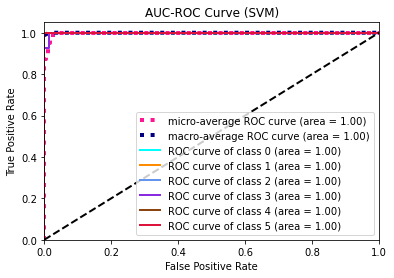

In [21]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

# Standardizing the features
X = StandardScaler().fit_transform(X)

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = OneVsRestClassifier(SVC(random_state=42)).fit(X_train, y_train)

y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blueviolet', 'saddlebrown', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (SVM)')
plt.legend(loc="lower right")
plt.show()

# AUC-ROC Curve (OneVsRest Logistic Regression)

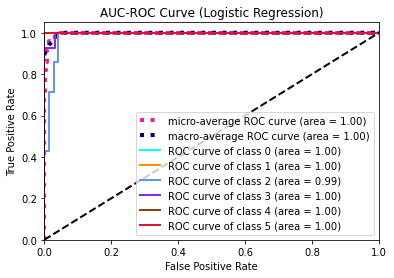

In [22]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

# Standardizing the features
X = StandardScaler().fit_transform(X)

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = OneVsRestClassifier(LogisticRegression(random_state=0,solver='lbfgs', max_iter=1000)).fit(X_train, y_train)

y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blueviolet', 'saddlebrown', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

# AUC-ROC Curve (OneVsRest RandomForest)

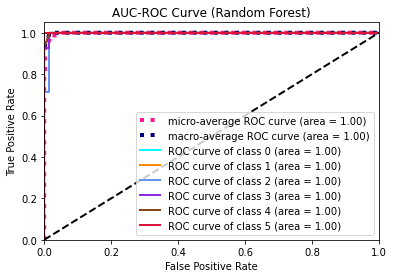

In [23]:
X = df[selected_feats].to_numpy()
y = df['label'].to_numpy()

# Standardizing the features
X = StandardScaler().fit_transform(X)

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = OneVsRestClassifier(RandomForestClassifier(random_state=0)).fit(X_train, y_train)

y_score = clf.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blueviolet', 'saddlebrown', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve (Random Forest)')
plt.legend(loc="lower right")
plt.show()

In [24]:
from helper import compare_classifier_score

In [25]:
print('Without standardization and with no feature selection')

compare_classifier_score(df, standardization=False, featureSelection='none')

print('Without standardization and with random forest feature selection')

compare_classifier_score(df, standardization=False, featureSelection='randomForest')

print('Without standardization and with pca feature selection')

compare_classifier_score(df, standardization=False, featureSelection='pca')

print('With standardization and with no feature selection')

compare_classifier_score(df, standardization=True, featureSelection='none')

print('With standardization and with random forest feature selection')

compare_classifier_score(df, standardization=True, featureSelection='randomForest')

print('With standardization and with pca feature selection')

compare_classifier_score(df, standardization=True, featureSelection='pca')

Without standardization and with no feature selection
cross fold validation score average for Random Forest: 0.9692307692307693
cross fold validation score average for Logistic Regression: 0.7841538461538462
cross fold validation score average for SVM: 0.22430769230769232
cross fold validation score average for Nearest Neighbors: 0.6066153846153847
cross fold validation score average for Naive Bayes: 0.7766153846153846
Without standardization and with random forest feature selection
cross fold validation score average for Random Forest: 0.9692307692307693
cross fold validation score average for Logistic Regression: 0.9343076923076923
cross fold validation score average for SVM: 0.45199999999999996
cross fold validation score average for Nearest Neighbors: 0.8807692307692306
cross fold validation score average for Naive Bayes: 0.8266153846153846
Without standardization and with pca feature selection
cross fold validation score average for Random Forest: 0.7415384615384615
cross fold val